<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/dbda/ch09-heirarchical-models/heirarchical_on_mint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
from runpy import run_path

az.style.use('arviz-darkgrid')
%matplotlib inline

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 16.5MB/s 
     |████████████████████████████████| 286kB 31.7MB/s 
     |████████████████████████████████| 911kB 2.8MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [2]:
!rm -rf data-science-hw
!git clone https://github.com/ctarrington/data-science-hw.git

base_path = './data-science-hw/dbda/ch08-basic-models/'
Coin = run_path(base_path+'/mint.py').get('Coin')
Mint = run_path(base_path+'/mint.py').get('Mint')

Cloning into 'data-science-hw'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 187 (delta 84), reused 39 (delta 8), pack-reused 0
Receiving objects: 100% (187/187), 5.05 MiB | 14.99 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [3]:
coins_per_mint = 5
mint = Mint(0.3, 0.025)
coins = mint.make_coins(coins_per_mint)

mint = Mint(0.7, 0.025)
mint.make_coins(coins_per_mint, coins)

In [4]:
flips = []
for ctr in range(50):
  for coin in coins:
    coin.flip(flips)

In [5]:
df = pd.DataFrame(flips, columns=['mint_id', 'coin_id', 'flip'])
df.head()

,mint_id,coin_id,flip
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,0
4,0,4,0


In [6]:
coin_id = df['coin_id']
mint_id = df['mint_id']

num_coins = len(np.unique(coin_id))
num_mints = len(np.unique(mint_id))

print('num_coins', num_coins)
print('num_mints', num_mints)

num_coins 10
num_mints 2


## No Heirarchy - Coins

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:04<00:00, 601.03it/s]


       mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
θ[0]  0.290  0.063   0.175    0.407  ...  5334.0    5677.0    3237.0    1.0
θ[1]  0.231  0.058   0.129    0.344  ...  4533.0    4870.0    2928.0    1.0
θ[2]  0.248  0.060   0.137    0.359  ...  4717.0    4936.0    2844.0    1.0
θ[3]  0.327  0.063   0.221    0.455  ...  5189.0    5461.0    2878.0    1.0
θ[4]  0.384  0.066   0.261    0.509  ...  5899.0    5933.0    2970.0    1.0
θ[5]  0.655  0.063   0.538    0.776  ...  4506.0    4572.0    3179.0    1.0
θ[6]  0.635  0.068   0.511    0.761  ...  4703.0    4714.0    2492.0    1.0
θ[7]  0.729  0.061   0.614    0.839  ...  4695.0    4651.0    2613.0    1.0
θ[8]  0.692  0.063   0.577    0.809  ...  4698.0    4709.0    2951.0    1.0
θ[9]  0.770  0.056   0.665    0.871  ...  5343.0    5274.0    3005.0    1.0

[10 rows x 11 columns]


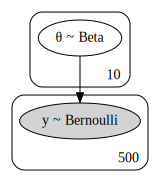

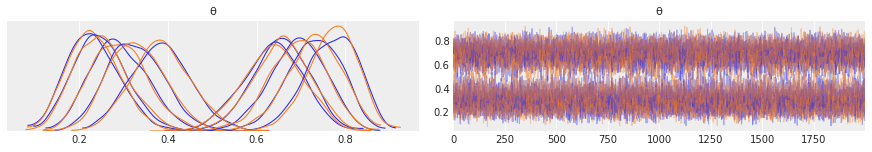

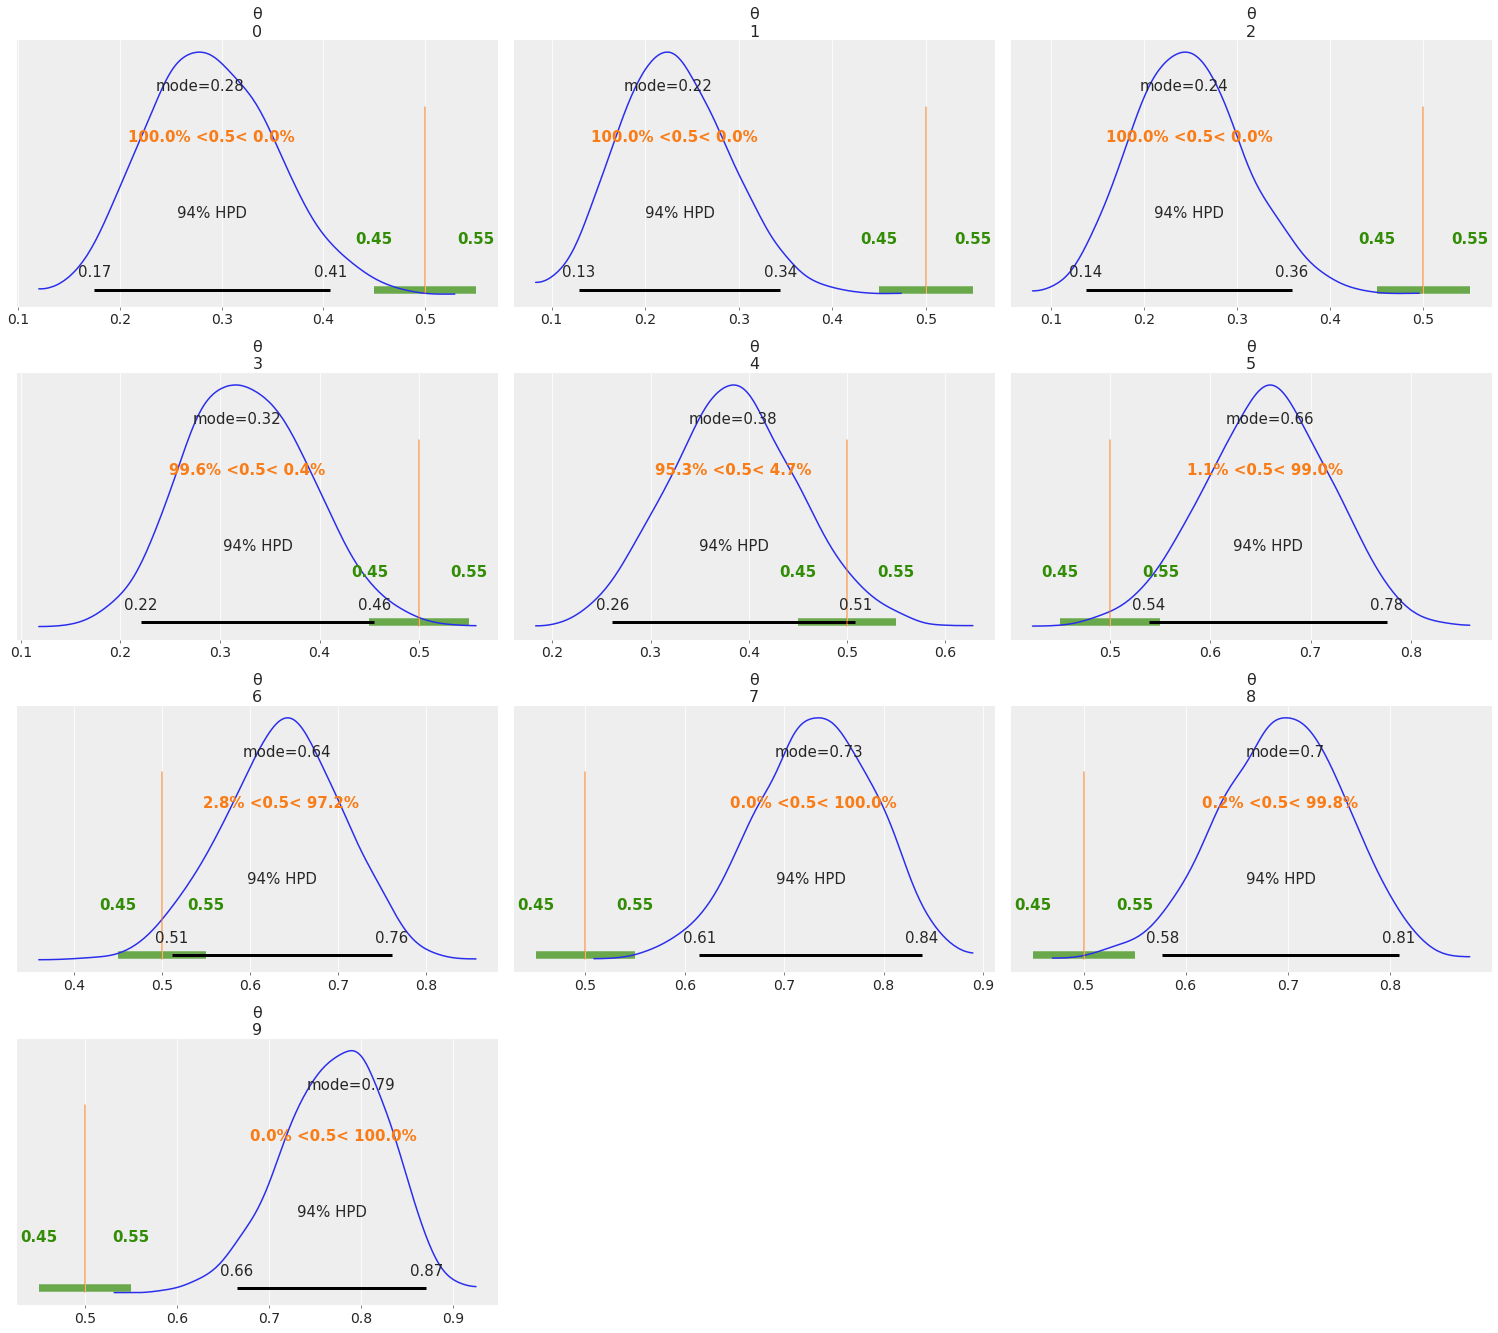

In [7]:
with pm.Model() as model:
  θ = pm.Beta('θ', alpha=1., beta=1., shape=num_coins)   # uniform prior
  
  y = pm.Bernoulli('y', p=θ[coin_id], observed=df['flip']) # likelihood p(y|θ)

  trace = pm.sample(2000, random_seed=123)
  print(az.summary(trace))
  pm.traceplot(trace)
  az.plot_posterior(trace, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model)

## No Heirarchy - Mints


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:02<00:00, 999.90it/s] 


       mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
θ[0]  0.289  0.028   0.236    0.342  ...  3423.0    3491.0    3126.0    1.0
θ[1]  0.702  0.029   0.650    0.757  ...  3092.0    3069.0    2507.0    1.0

[2 rows x 11 columns]


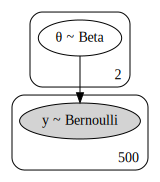

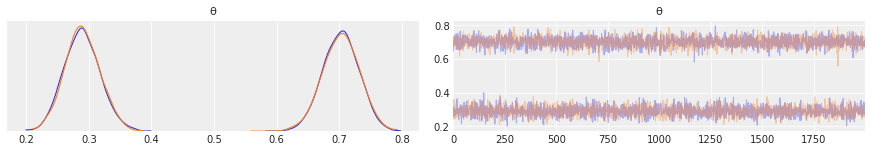

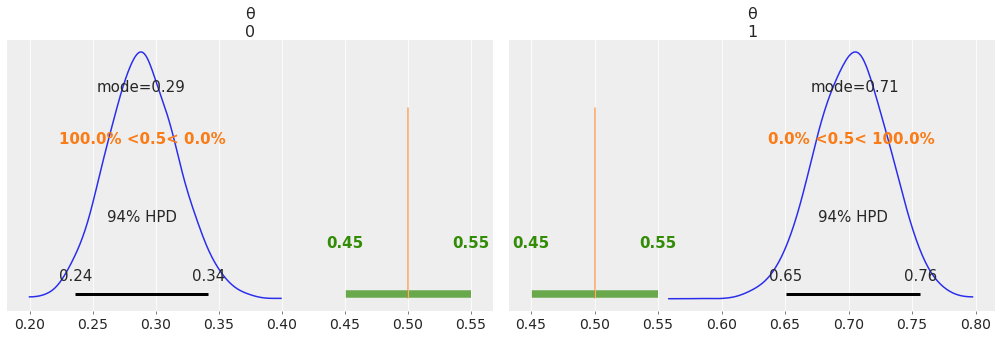

In [8]:
mint_id = df['mint_id']

with pm.Model() as model:
  θ = pm.Beta('θ', alpha=1., beta=1., shape=num_mints)   # uniform prior
  
  y = pm.Bernoulli('y', p=θ[mint_id], observed=df['flip']) # likelihood p(y|θ)

  trace = pm.sample(2000, random_seed=123)
  print(az.summary(trace))
  pm.traceplot(trace)
  az.plot_posterior(trace, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model)

## Heirarchy under Mint

In [9]:
grouped = df.groupby(['mint_id', 'coin_id']).agg({'flip': [np.sum, np.size]}).reset_index()
grouped.columns = ['mint_id', 'coin_id', 'heads', 'total']

# mint id series needs to be the length of the mints
mint_id = grouped['mint_id']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ_coin, concentration_mint, μ_mint]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:07<00:00, 344.46it/s]


                         mean     sd  hpd_3%  ...  ess_bulk  ess_tail  r_hat
μ_mint[0]               0.309  0.064   0.197  ...    5319.0    3383.0    1.0
μ_mint[1]               0.683  0.063   0.571  ...    4552.0    2630.0    1.0
concentration_mint[0]  13.878  6.102   3.755  ...    4217.0    2313.0    1.0
concentration_mint[1]  14.220  6.379   3.236  ...    4468.0    2779.0    1.0
θ_coin[0]               0.286  0.057   0.181  ...    6351.0    2973.0    1.0
θ_coin[1]               0.238  0.054   0.136  ...    7210.0    2927.0    1.0
θ_coin[2]               0.253  0.055   0.151  ...    7227.0    2728.0    1.0
θ_coin[3]               0.317  0.059   0.205  ...    7384.0    2891.0    1.0
θ_coin[4]               0.363  0.064   0.247  ...    7759.0    2832.0    1.0
θ_coin[5]               0.665  0.060   0.556  ...    7966.0    3082.0    1.0
θ_coin[6]               0.650  0.059   0.543  ...    7911.0    3256.0    1.0
θ_coin[7]               0.729  0.057   0.622  ...    6779.0    3194.0    1.0

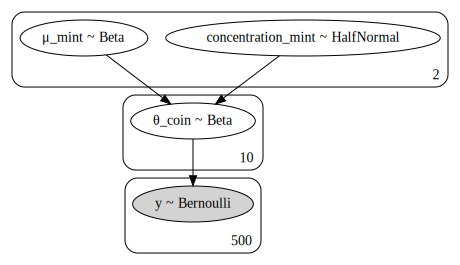

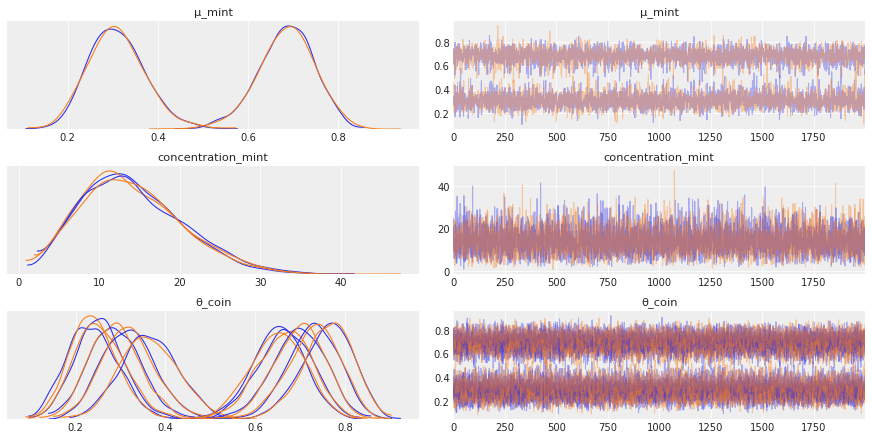

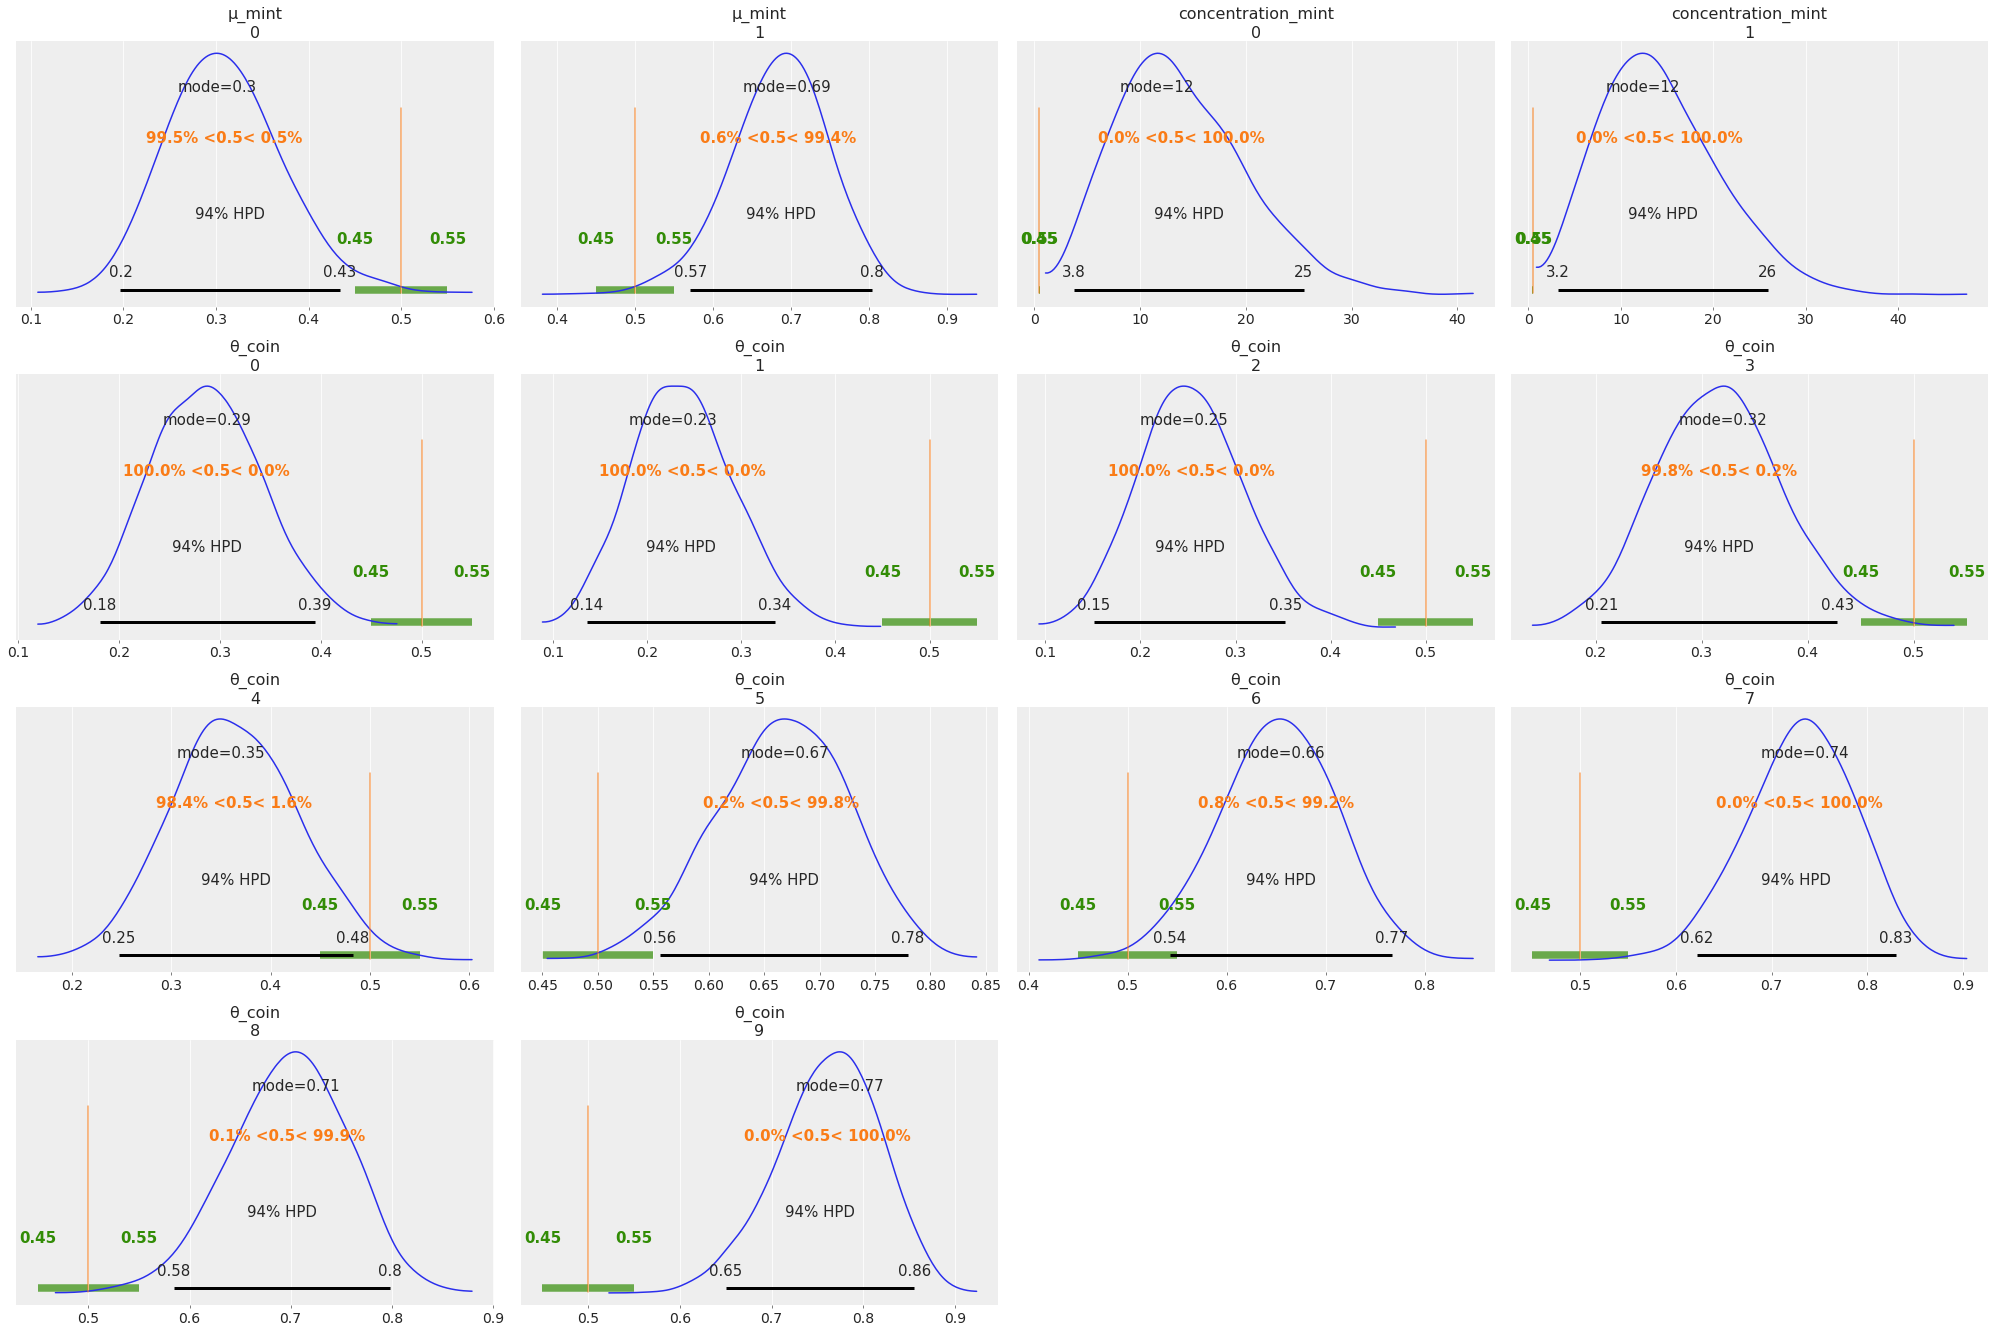

In [10]:
with pm.Model() as model_h_mint:
    μ_mint = pm.Beta('μ_mint', 1, 1, shape=num_mints)
    concentration_mint = pm.HalfNormal('concentration_mint', 10, shape=num_mints)    

    θ_coin = pm.Beta('θ_coin', alpha=μ_mint[mint_id]*concentration_mint[mint_id], beta=(1.0-μ_mint[mint_id])*concentration_mint[mint_id], shape=num_coins)
    y = pm.Bernoulli('y', p=θ_coin[coin_id], observed=df['flip']) # likelihood p(y|θ)
  
    trace = pm.sample(2000, random_seed=123)
    print(az.summary(trace))
    pm.traceplot(trace)
    az.plot_posterior(trace, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_h_mint)